In [1]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import random
import math
from tqdm import tqdm
import numpy as np
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def to_one_hot(x: Tensor) -> Tensor:
    return torch.eye(x.max() + 1)[x]
def collate(x) -> Tensor:
    if isinstance(x, (tuple, list)):
        if isinstance(x[0], Tensor):
            return torch.stack(x)
        return torch.tensor(x)
    raise "Not supported yet"

In [4]:
def rotate_image(image, angle_degrees):
    center = (image.shape[1] / 2, image.shape[0] / 2)

    rot_mat = cv2.getRotationMatrix2D(center, angle_degrees, 1.0)
    rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

    return rotated_image

In [5]:
def load_mnist(path: str = "./data", train: bool = True, pin_memory: bool = True):
    mnist_raw = MNIST(path, download=True, train=train)
    mnist_data = []
    mnist_labels = []
    for image, label in mnist_raw:
        tensor = torch.from_numpy(np.array(image))
        mnist_data.append(tensor)
        mnist_labels.append(label)

        # if train:
        #     pixel = 1
        #     img_shifted_1 = torch.cat((255 * torch.ones(size=(pixel, 28)), tensor[pixel:, :]))
        #     img_shifted_2 = torch.cat((tensor[:28-pixel, :], 255 * torch.ones(size=(pixel, 28))))
        #     img_shifted_3 = torch.cat((255 * torch.ones(size=(28, pixel)), tensor[:, pixel:]), dim=1)
        #     img_shifted_4 = torch.cat((tensor[:, :28-pixel], 255 * torch.ones(size=(28, pixel))), dim=1)

        #     for img in [img_shifted_1, img_shifted_2, img_shifted_3, img_shifted_4]:
        #         mnist_data.append(img)
        #         mnist_labels.append(label)

    mnist_data = collate(mnist_data).float()  # shape 60000, 28, 28
    mnist_data = mnist_data.flatten(start_dim=1)  # shape 60000, 784
    mnist_data /= mnist_data.max()  # min max normalize
    mnist_labels = collate(mnist_labels)  # shape 60000
    mnist_labels = to_one_hot(mnist_labels)  # shape 60000, 10
    if pin_memory:
        return mnist_data.pin_memory(), mnist_labels.pin_memory()
    return mnist_data, mnist_labels

In [6]:
pin_memory = device.type == 'cuda'
data, labels = load_mnist(train=True, pin_memory=pin_memory)
data_test, labels_test = load_mnist(train=False, pin_memory=pin_memory)

100%|██████████| 9912422/9912422 [00:00<00:00, 117380190.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68092014.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34135524.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23577387.09it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
print(len(data))
print(len(data_test))

60000
10000


In [8]:
def relu(x):
    return torch.max(x, torch.zeros_like(x))
def prelu(x, alpha):
    return torch.where(x >= 0, x, alpha * x)
def elu(x, alpha=1.0):
    return torch.where(x >= 0, x, alpha * (torch.exp(x) - 1))
def leaky_relu(x, alpha=0.01):
    return torch.where(x >= 0, x, alpha * x)

def relu_derivative(x):
    return torch.where(x > 0, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
def prelu_derivative(x, alpha):
    return torch.where(x >= 0, torch.tensor(1.0), alpha)
def elu_derivative(x, alpha=1.0):
    return torch.where(x >= 0, torch.tensor(1.0), torch.exp(x) + alpha)
def leaky_relu_derivative(x, alpha=0.01):
    derivative = torch.ones_like(x)
    derivative[x < 0] = alpha
    return derivative

In [9]:
class MLP:
    def __init__(self, input_size, hidden_layer, output_size, lr, device):
        self.device = device
        self.weights1 = torch.rand((input_size, hidden_layer), device=device)
        self.biases1 = torch.rand((hidden_layer,), device=device)

        self.weights2 = torch.rand((hidden_layer, output_size), device=device)
        self.biases2 = torch.rand((output_size,), device=device)

        self.lr = lr
        self.dropout_prob = 0.2

    def forward(self, inputt, train):
        self.x = inputt
        self.batch = inputt.shape[0]

        z1 = self.x @ self.weights1 + self.biases1
        self.activ1 = relu(z1)
        self.activ1 = self.__dropout(self.activ1, train)

        z2 = self.activ1 @ self.weights2 + self.biases2
        self.activ2 = z2.softmax(dim=1)

        return self.activ2

    def backward(self, label):
        self.err2 = self.activ2 - label
        self.err1 = relu_derivative(self.activ1) * (self.err2 @ self.weights2.T)

        self.d_w1 = self.x.T @ self.err1
        self.d_b1 = self.err1.mean(axis=0)

        self.d_w2 = self.activ1.T @ self.err2
        self.d_b2 = self.err2.mean(axis=0)

    def update(self):
        self.weights1 -= (self.lr * self.d_w1 / self.batch)
        self.biases1 -= (self.lr * self.d_b1)

        self.weights2 -= (self.lr * self.d_w2 / self.batch)
        self.biases2 -= (self.lr * self.d_b2)

    def predict(self, inputt):
        output = self.forward(inputt, False)

        return output

    def modify_lr(self, lr):
        self.lr = lr

    def __dropout(self, input_data, train):
        if train:
            mask = ((torch.rand(input_data.shape, device=self.device) < (1 - self.dropout_prob)) / (1 - self.dropout_prob))
            return input_data * mask
        return input_data

In [10]:
batch = 256
eval_batch_size = 10000
init_lr = 0.08
epochs = 1000
model = MLP(784, 100, 10, init_lr, device)

loss_values = []
metric_val = []
best_acc = 0.0

loss_function = torch.nn.CrossEntropyLoss()

In [11]:
def poly_lr(ep, max_ep, initial_lr, exponent=0.9):
    return initial_lr * (1 - ep / max_ep)**exponent

In [12]:
non_blocking = device.type == 'cuda'

var = tqdm(range(epochs))
for epoch in var:
    model.modify_lr(poly_lr(epoch, epochs, init_lr, 0.9))

    train_loss = 0.0
    train_acc = 0.0

    step = 0
    for i in range(0, data.shape[0], batch):
        step += 1
        x = data[i: i + batch].to(device, non_blocking=non_blocking)
        y = labels[i: i + batch].to(device, non_blocking=non_blocking)

        outputs = model.forward(x, True)

        loss = loss_function(outputs, y)
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, axis=1) == torch.argmax(y, axis=1)).sum().item()

        model.backward(y)
        model.update()

    train_loss /= step
    train_acc /= len(data)
    loss_values.append(train_loss)
################################################################################################
    test_loss = 0.0
    test_acc = 0

    step = 0
    for i in range(0, data_test.shape[0], eval_batch_size):
        step += 1
        x = data_test[i: i + eval_batch_size].to(device, non_blocking=non_blocking)
        y = labels_test[i: i + eval_batch_size].to(device, non_blocking=non_blocking)

        outputs = model.predict(x)

        loss = loss_function(outputs, y)
        test_loss += loss.item()
        test_acc += (torch.argmax(outputs, axis=1) == torch.argmax(y, axis=1)).sum().item()

    test_loss /= step
    test_acc /= len(data_test)
    metric_val.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model

    var.set_postfix_str(f"train_loss: {train_loss}, train_acc: {train_acc}, test_loss: {test_loss}, test_acc: {test_acc}, best accuracy = {best_acc}")

100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s, train_loss: 1.5048314226434585, train_acc: 0.9718, test_loss: 1.4986295700073242, test_acc: 0.9725, best accuracy = 0.9729]


In [13]:
print(best_acc)

0.9729


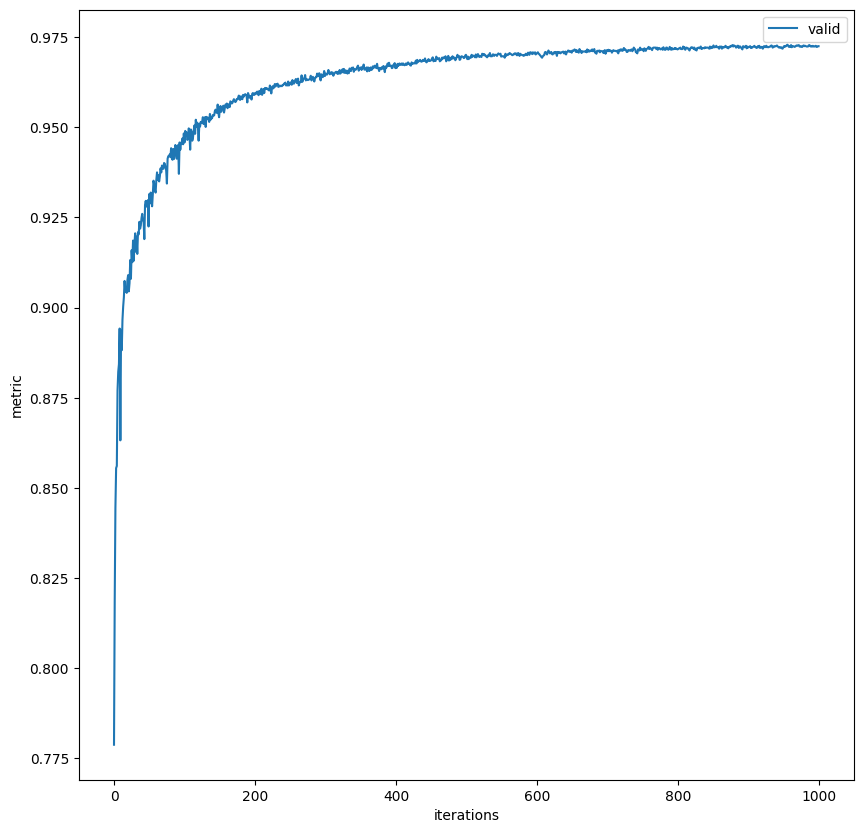

In [14]:
plt.figure(figsize=(10,10))
plt.plot(metric_val, label='valid')
plt.xlabel("iterations")
plt.ylabel('metric')
plt.legend()
plt.show()

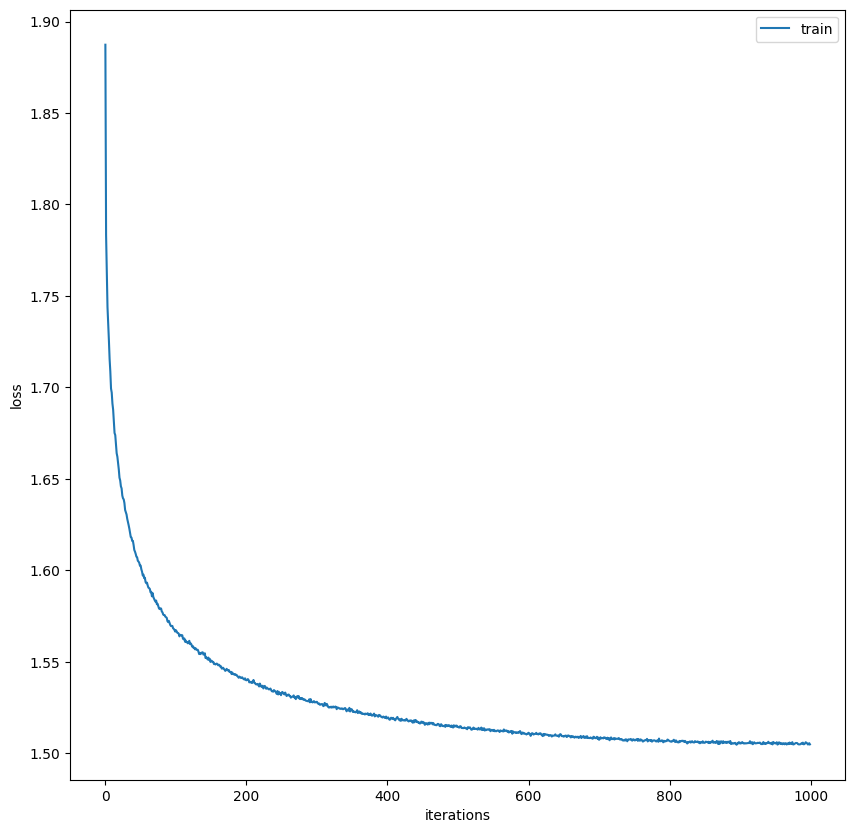

In [15]:
plt.figure(figsize=(10,10))
plt.plot(loss_values, label='train')
plt.xlabel("iterations")
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
import pickle

with open("model.pkl", "wb") as file:
    pickle.dump(best_model, file)